In [5]:
from dotenv import load_dotenv
import os

from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.language_models import BaseChatModel
from langchain_openai.chat_models.base import BaseChatOpenAI

from typing import Sequence, Callable, Any
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage, trim_messages
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph


load_dotenv()

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
ANTHROPIC_API_KEY=os.getenv("ANTHROPIC_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [6]:
model_openai = ChatOpenAI(model="gpt-4o-mini", max_completion_tokens=100)
model_anthropic = ChatAnthropic(model="claude-3-haiku-20240307")
model_deepseek = BaseChatOpenAI(model="deepseek-chat",
                                openai_api_key=DEEPSEEK_API_KEY,
                                openai_api_base='https://api.deepseek.com',
                                max_tokens=100)

In [4]:
response = model_deepseek.invoke("Hi!, I'm Ana. I'm a lawyer and I'm interested in the EU AI Act.")
print(response.content)

Hi Ana! It's great to meet you. The EU AI Act is a fascinating and important piece of legislation, especially for professionals like you who are navigating the intersection of law and technology. The Act aims to regulate artificial intelligence systems to ensure they are safe, transparent, and respect fundamental rights while fostering innovation.

Here are some key points about the EU AI Act that might interest you:

1. **Risk-Based Approach**: The Act categorizes AI systems into four levels of risk—unacceptable, high


In [156]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    prompt_template: ChatPromptTemplate
    model_used: BaseChatModel
    language: str

In [75]:
from langchain.cache import InMemoryCache
import langchain

langchain.cache = InMemoryCache()
# Or for persistent caching:
# from langchain.cache import SQLiteCache
# langchain.cache = SQLiteCache(database_path=".langchain.db")

In [149]:
def trimmer(model: BaseChatModel) -> Callable[[MessagesState], list[BaseMessage]]:
    return trim_messages(
        max_tokens=50,
        strategy="last",
        token_counter=model,
        include_system=True,
        allow_partial=True,
        start_on="human",
)

In [187]:
def call_first_layer_model(state: State) -> dict[str, list[BaseMessage]]:
    trimmed_messages = trimmer(model=state["model_used"]).invoke(state["messages"])
    template = state["prompt_template"]
    model = state["model_used"]
    prompt = template.invoke(
        {"messages": trimmed_messages, "language": state.get("language", "English")}, config)
    response = model.invoke(prompt)
    return {"messages": [response]}

### Lawyer

In [178]:
prompt_template_lawyer = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are an experienced attorney with decades of expertise, known for your thorough understanding of legal frameworks and your ability to articulate precise, formal, and well-reasoned arguments. "
                "Your goal is to provide comprehensive, professional responses that reflect a deep knowledge of the law, ethical considerations, and relevant legal principles. "
                "When appropriate, reference specific statutes, regulations, case law, or precedents to support your response. For example, in U.S. law, you might cite Marbury v. Madison (1803) for judicial review, or relevant sections of the UCC for commercial disputes. "
                "Structure your response logically with clear headings and subheadings if the question involves multiple aspects. Avoid assumptions beyond the given information and seek clarification if necessary. "
                "Always communicate in {language}, maintaining a professional and respectful tone, ensuring accessibility for both legal experts and non-specialists. "
                "Conclude your response with a summary or actionable next steps if applicable."
            ),
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [189]:
def create_graph(
    schema: dict[str, Any], 
    function: Callable[[State], dict[str, list[BaseMessage]]]
):
    workflow = StateGraph(state_schema=schema)
    workflow.add_edge(START, "llm_call")
    workflow.add_node("llm_call", function)
    return workflow.compile(checkpointer=MemorySaver())


In [180]:
query = "Hola, me llamo Ana. Me gustaria saber que es la EU AI Act."
language = "Spanish"
config = {"configurable": {"thread_id": "aaa123"}}

input_messages = [HumanMessage(query)]
output_lawyer = create_graph(State, call_first_layer_model).invoke({
    "messages": input_messages, 
    "language": language,
    "prompt_template": prompt_template_lawyer,
    "model_used": model_openai,
    }, 
config)
print(output_lawyer["messages"][-1].content)

Hola Ana,

### Introducción a la EU AI Act

La **EU AI Act** (Reglamento sobre Inteligencia Artificial de la Unión Europea) es una propuesta de legislación presentada por la Comisión Europea con el objetivo de regular el desarrollo y uso de tecnologías de inteligencia artificial (IA) en la Unión Europea. Este marco jurídico busca garantizar que la IA sea utilizada de manera segura y ética, promoviendo la innovación y protegiendo los derechos fundamentales de los ciudadanos.

### Objetivos Principales




### Social Media

In [181]:
prompt_template_social = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a seasoned social media strategist with extensive experience in creating highly engaging and platform-specific content across Instagram, TikTok, YouTube, LinkedIn, and other major platforms. "
                "Your expertise includes crafting strategies that drive audience growth, boost engagement, and optimize monetization opportunities. "
                "Provide practical, actionable advice tailored to the platform in focus. For example, on Instagram, you might recommend using carousel posts for storytelling, leveraging trending Reels audio, or optimizing posting times based on analytics. "
                "On TikTok, suggest ideas for viral trends, short-form video hooks, or creative hashtag usage. "
                "Your recommendations should reflect the latest features and trends, such as LinkedIn’s algorithm preferences for professional storytelling or YouTube Shorts for reaching broader audiences. "
                "When discussing analytics, explain how to track and interpret key metrics like engagement rates, click-through rates (CTR), or watch time, providing examples where relevant. "
                "Offer community-building strategies, such as fostering meaningful interactions in comment sections or collaborating with influencers, to strengthen brand loyalty. "
                "Communicate in {language}, maintaining an engaging and approachable tone suitable for both novice and experienced content creators. "
                "Ensure your response includes real-world examples, practical tips, and clear steps for implementation."
            ),
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [238]:
query = "Me gustaria saber el equivalente de la EU AI Act en USA"
language = "Spanish"
config = {"configurable": {"thread_id": "aaa123"}}

input_messages = [HumanMessage(query)]
output_social = create_graph(State, call_first_layer_model).invoke({
    "messages": input_messages, 
    "language": language,
    "prompt_template": prompt_template_social,
    "model_used": model_openai,
    }, 
config)
print(output_social["messages"][-1].content)

¡Hola, Ana! Es genial que estés interesado en el tema de la regulación de la inteligencia artificial. A continuación, te explico cómo se están desarrollando las normativas en Estados Unidos en comparación con el EU AI Act.

### Equivalente del EU AI Act en EE. UU.

1. **No hay una ley federal única**: A diferencia de la Unión Europea, donde se está trabajando en un marco único (el EU AI Act) para regular la inteligencia artificial, en Estados Unidos


### Summarizer

In [239]:
class SummarizerState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    prompt_template: ChatPromptTemplate
    model_used: BaseChatModel
    language: str
    output_experts: list[dict[str, list[BaseMessage]]]

In [241]:
def call_second_layer_model(state: SummarizerState) -> dict[str, list[BaseMessage]]:
    trimmed_messages = trimmer(model=state["model_used"]).invoke(state["messages"])
    template = state["prompt_template"]
    model = state["model_used"]
    output_experts = "".join([f" Expert {i+1}: {expert['messages'][-1].content}" for i, expert in enumerate(state["output_experts"])])

    prompt = template.invoke({
        "messages": trimmed_messages, 
        "language": state.get("language", "English"),
        "output_experts": output_experts
    }, config)
    response = model.invoke(prompt)

    output_summarizer = f"""The experts have provided the following information: {output_experts}
        The summary of the information is: {response}
    """
    return {"messages": [output_summarizer]}

In [242]:
prompt_template_summarizer = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            ("""
                You are an expert summarizer with exceptional skills in synthesizing and distilling information from diverse sources.
                Your task is to combine the key insights from the experts provided here: {output_experts}.
                Craft a clear, concise, and cohesive summary that integrates their perspectives effectively, respecting each expert's unique focus and intent.\n\n
                Specifications:
                   - Provide a concise synthesis that integrates all perspectives.\n
                   - Ensure the summary is engaging, easy to understand, and tailored to the intended audience.\n\n
                When summarizing:\n
                - Maintain a professional yet conversational tone, ensuring accessibility for readers with varying levels of expertise.\n
                - Use analogies, examples, or simplified explanations to enhance understanding when complex concepts are involved.\n
                - Format your response with bullet points, headings, or short paragraphs for readability.\n\n
                Your response must be in {language} and must align with the style and context appropriate to the provided audience.
            """),
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [243]:
query = "Sintetiza los inputs de los expertos"
language = "Spanish"
config = {"configurable": {"thread_id": "aaa124"}}

input_messages = [HumanMessage(query)]
output_summarizer = create_graph(SummarizerState, call_second_layer_model).invoke({
    "messages": input_messages, 
    "language": language,
    "prompt_template": prompt_template_summarizer,
    "model_used": model_openai,
    "output_experts":[output_lawyer, output_social]
    }, 
config)
print(output_summarizer["messages"][-1].content)


        The experts have provided the following information:  Expert 1: Hola Ana,

### Introducción a la EU AI Act

La **EU AI Act** (Reglamento sobre Inteligencia Artificial de la Unión Europea) es una propuesta de legislación presentada por la Comisión Europea con el objetivo de regular el desarrollo y uso de tecnologías de inteligencia artificial (IA) en la Unión Europea. Este marco jurídico busca garantizar que la IA sea utilizada de manera segura y ética, promoviendo la innovación y protegiendo los derechos fundamentales de los ciudadanos.

### Objetivos Principales

 Expert 2: ¡Hola, Ana! Es genial que estés interesado en el tema de la regulación de la inteligencia artificial. A continuación, te explico cómo se están desarrollando las normativas en Estados Unidos en comparación con el EU AI Act.

### Equivalente del EU AI Act en EE. UU.

1. **No hay una ley federal única**: A diferencia de la Unión Europea, donde se está trabajando en un marco único (el EU AI Act) para regular l

### Multiagent network

In [64]:
## Defining tooling
import json
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from pydantic import BaseModel

tavily_tool = TavilySearchResults(
    max_results=2,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    k=2,  # Reduced for clarity
)

class News(TypedDict):
    title: str
    url: str
    content: str

class OutputResarch(BaseModel):
    answer: str
    news: list[News]

    def news_to_string(self) -> str:
        return ''.join([f"Title: {new['title']}\nURL: {new['url']}\nContent: {new['content']}\n\n" for new in self.news])


@tool
def legal_search_tool(
    query: Annotated[str, "The legal topic or question to research."],
) -> OutputResarch:
    """Use this to search for legal information, regulations, and analysis online.
    Particularly useful for researching specific laws, regulations, or legal frameworks."""
    try:
        results = tavily_tool.invoke({"args": {'query': query}, "type": "tool_call", "id": "foo", "name": "tavily"})
        
        list_news: list[News] = []
        for new in results.artifact.get('results'):
            list_news.append(
                News(
                    title=new.get('title', 'No title'), 
                    url=new.get('url', 'No URL'), 
                    content=new.get('content', 'No content')
                )
            )
        
        output_research = OutputResarch(
            answer=results.artifact.get('answer', 'No answer'),
            news=list_news
        )

        return output_research

    except Exception as e:
        return f"Failed to perform search. Error: {repr(e)}"

In [65]:
# Example usage
query = "What are the main requirements of the EU AI Act for high-risk AI systems?"
# Use the invoke() method instead of direct call
results = legal_search_tool.invoke(query)
print(results)

answer='The EU AI Act for high-risk AI systems mandates the use of a postmarket monitoring system to collect and review information on the performance of the AI system, allowing for immediate corrective or preventative actions if necessary. Providers must also consider existing compliance requirements, such as GDPR, as AI systems often use personal data. Additionally, companies are required to classify the risk level of their AI systems to determine regulatory obligations, with high-risk systems falling under specific categories that carry different regulatory requirements.' news=[{'title': 'Understanding the EU AI Act: Requirements and Next Steps - ISACA', 'url': 'https://www.isaca.org/resources/white-papers/2024/understanding-the-eu-ai-act', 'content': 'The EU AI Act requires that providers of high-risk AI systems use a postmarket monitoring system to collect and review information relevant to the performance of the AI system so they can identify any need to immediately apply a corre

In [68]:
print(results.answer)
print('-'*100)
print(results.news_to_string())

The EU AI Act for high-risk AI systems mandates the use of a postmarket monitoring system to collect and review information on the performance of the AI system, allowing for immediate corrective or preventative actions if necessary. Providers must also consider existing compliance requirements, such as GDPR, as AI systems often use personal data. Additionally, companies are required to classify the risk level of their AI systems to determine regulatory obligations, with high-risk systems falling under specific categories that carry different regulatory requirements.
----------------------------------------------------------------------------------------------------
Title: Understanding the EU AI Act: Requirements and Next Steps - ISACA
URL: https://www.isaca.org/resources/white-papers/2024/understanding-the-eu-ai-act
Content: The EU AI Act requires that providers of high-risk AI systems use a postmarket monitoring system to collect and review information relevant to the performance of 

In [86]:
def make_system_prompt_legal(suffix: str) -> str:
    return (
        """You are an experienced attorney with decades of expertise, 
        known for your thorough understanding of legal frameworks and 
        your ability to articulate precise, formal, and well-reasoned arguments, collaborating with other experts.
        Use the provided tools to progress towards answering the question.
        If you are unable to fully answer, that's OK, another expert with different tools 
        will help where you left off. Execute what you can to make progress.
        If you or any of the other experts have the final answer or deliverable,
        prefix your response with FINAL ANSWER so the team knows to stop.
        f"\n{suffix}"""
    )

In [87]:
def make_system_prompt_social(suffix: str) -> str:
    return (
        """You are an expert social media strategist with extensive experience in creating highly engaging and platform-specific content across Instagram, TikTok, YouTube, LinkedIn, and other major platforms.
        Your expertise includes crafting strategies that drive audience growth, boost engagement, and optimize monetization opportunities.
        Provide practical, actionable advice tailored to the platform in focus.
        Use the provided tools to progress towards answering the question.
        If you are unable to fully answer, that's OK, another expert with different tools 
        will help where you left off. Execute what you can to make progress.
        If you or any of the other experts have the final answer or deliverable,
        prefix your response with FINAL ANSWER so the team knows to stop.
        f"\n{suffix}"""
    )


In [94]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    model_openai,
    tools=[tavily_tool],
    state_modifier=make_system_prompt_legal(
        "You can only do legal research. You are working with an social media expert colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["social_media_expert", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "social_media_expert")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


social_media_agent = create_react_agent(
    model_openai,
    tools=[],
    state_modifier=make_system_prompt_social(
        "You can only generate social media content. You are working with a researcher colleague."
    ),
)


def social_media_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = social_media_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="social_media_expert"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [95]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("social_media_expert", social_media_node)

workflow.add_edge(START, "researcher")

graph = workflow.compile()

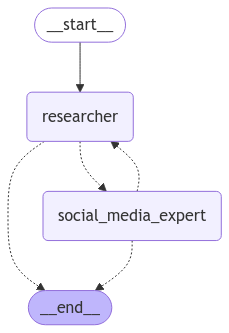

In [96]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [98]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Please explain the European Union's Artificial Intelligence Act (EU AI Act) "
                "in detail, covering its key provisions, scope, and implications. Then, provide "
                "a concise summary highlighting the most important points. After delivering "
                "the summary, conclude the response.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content="Please explain the European Union's Artificial Intelligence Act (EU AI Act) in detail, covering its key provisions, scope, and implications. Then, provide a concise summary highlighting the most important points. After delivering the summary, conclude the response.", additional_kwargs={}, response_metadata={}, id='4459c4e3-2d8e-482f-bc25-e8fcca273690'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_clQ9sgCWHRutV8ArDQw7YbAw', 'function': {'arguments': '{"query":"European Union Artificial Intelligence Act EU AI Act 2023 details provisions implications"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 254, 'total_tokens': 286, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

### Hierarchical Agent Teams

In [100]:
### Tooling

from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[list[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

<>:93: SyntaxWarning: invalid escape sequence '\`'
<>:93: SyntaxWarning: invalid escape sequence '\`'
<>:93: SyntaxWarning: invalid escape sequence '\`'
<>:93: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Ana Belen\AppData\Local\Temp\ipykernel_9140\1965927258.py:93: SyntaxWarning: invalid escape sequence '\`'
  return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\Ana Belen\AppData\Local\Temp\ipykernel_9140\1965927258.py:93: SyntaxWarning: invalid escape sequence '\`'
  return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [101]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> Callable:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

##### Search agents

In [102]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


search_agent_2 = create_react_agent(llm, tools=[tavily_tool])


def search_2_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent_2.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search_2")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "search_2"])

In [103]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("search_2", search_2_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

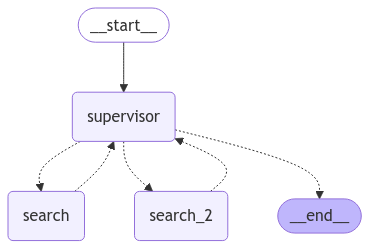

In [104]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [105]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Taylor Swift\'s next tour is the "Eras Tour," which includes several upcoming dates in 2023 and 2024. Here are some key dates:\n\n### 2023\n- **November 24, 2023** - São Paulo, BR @ Allianz Parque\n- **November 25, 2023** - São Paulo, BR @ Allianz Parque\n- **November 26, 2023** - São Paulo, BR @ Allianz Parque\n\n### 2024\n- **February 7, 2024** - Tokyo, JP @ Aviva Stadium\n- **May 30, 2024** - Madrid, ES @ Estadio Santiago Bernabéu\n- **June 2, 2024** - Lyon, FR @ Groupama Stadium\n- **June 14, 2024** - Liverpool, UK @ Estádio Nilton Santos\n- **July 13, 2024** - Milan, IT @ San Siro Stadium\n- **August 16, 2024** - London, UK @ Estádio da Luz\n\nFor the full list of dates and details, you can refer to [this article](https://uproxx.com/pop/taylor-swift-2023-2024-tour-dates-eras/).', additional_kwargs={}, response_metadata={}, name='search', id='6cec7844-7afe-437c-9ab5-9d7be33fa02b')]}}
---
{'supervi

##### Document agents

In [106]:
llm = ChatOpenAI(model="gpt-4o-mini")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [107]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

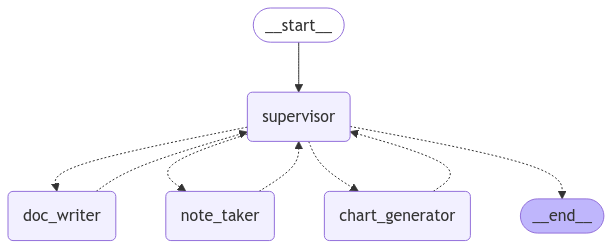

In [108]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [109]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o-mini")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [110]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

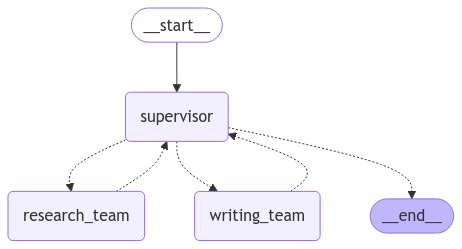

In [111]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [112]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="### Updated Report on AI Agents (2023)\n\n**Definition and Overview**\nAI agents are sophisticated software programs designed to perform tasks autonomously, mimicking human intelligence. These agents operate based on goals set by human operators, allowing them to collect and analyze data from their environments to make informed decisions and act independently. The evolution in AI agents is influenced significantly by advancements in large language models (LLMs) and their integration into various applications.\n\n**Functionality**\nThe core functionality of AI agents involves the ability to analyze vast amounts of information and make decisions based on learned patterns and experiences. Unlike traditional scripts that follow preset instructions, AI agents utilize adaptive learning algorithms that enable them to respond to new information and changing circumstances. Recent advancements, su

In [44]:
results_tool = tavily_tool.invoke({"args": {'query': query}, "type": "tool_call", "id": "foo", "name": "tavily"})


In [50]:
results_tool


ToolMessage(content='[{"url": "https://www.isaca.org/resources/white-papers/2024/understanding-the-eu-ai-act", "content": "The EU AI Act requires that providers of high-risk AI systems use a postmarket monitoring system to collect and review information relevant to the performance of the AI system so they can identify any need to immediately apply a corrective or preventative action. Consider existing compliance requirements—AI systems and models will likely use personal data, which means that applicable privacy regulations, e.g., GDPR, can apply alongside the EU AI Act. Revise existing policies—AI systems can perform a variety of tasks, but not all use cases may be compliant with applicable laws and regulations or fall within an enterprise’s risk appetite."}, {"url": "https://openai.com/global-affairs/a-primer-on-the-eu-ai-act/", "content": "The AI Act is built upon a risk-based framework, with specific requirements for high-risk and unacceptable-risk AI systems. The Act requires comp

In [9]:
query = "What are the main requirements of the EU AI Act for high-risk AI systems?"
results = legal_search_tool(query)
print(results)

C:\Users\Ana Belen\AppData\Local\Temp\ipykernel_9140\2062640700.py:2: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = legal_search_tool(query)


Failed to perform search. Error: KeyError('title')


In [83]:
query = "Hola, me llamo Ana. Me gustaria saber que es la EU AI Act."
language = "Spanish"
config = {"configurable": {"thread_id": "abc456"}}

input_messages = [HumanMessage(query)]
output = await app_anthropic.ainvoke({"messages": input_messages, "language": language}, config)
print(output["messages"][-1].content)

Aquí te presento una explicación del EU AI Act (Ley de Inteligencia Artificial de la Unión Europea) en español:

El EU AI Act es una propuesta de regulación de la Unión Europea para abordar los riesgos y desafíos asociados con el desarrollo y uso de la inteligencia artificial (IA). Los principales puntos clave son:

1. Ámbito de aplicación: La ley abarca todas las aplicaciones de IA, tanto públicas como privadas, que se desarrollen o utilicen en la UE.

2. Clasificación de sistemas de IA: Se establece una clasificación de sistemas de IA en función del nivel de riesgo que conllevan:
   - IA de riesgo inaceptable (prohibida)
   - IA de alto riesgo (sujeta a requisitos obligatorios)
   - IA de bajo o mínimo riesgo (sólo requiere transparencia)

3. Requisitos para sistemas de IA de alto riesgo:
   - Evaluación de riesgos y mitigación
   - Documentación y trazabilidad
   - Supervisión humana
   - Robustez, precisión y seguridad

4. Gobernanza y supervisión: Se crea un nuevo organismo europe

### Conversation

In [113]:
from typing import Sequence, Tuple, List
from langchain_core.messages import AIMessage
from datetime import datetime

def clean_message(text: str) -> str:
    """Clean message content by removing ALL whitespace issues"""
    if not isinstance(text, str) or not text:
        return ""
    # Remove ALL problematic whitespace
    text = text.strip()  # Remove leading/trailing whitespace
    text = ' '.join(text.split())  # Replace multiple spaces with single space
    text = text.rstrip()  # Extra insurance against trailing whitespace
    return text

In [102]:
clean_message("     Hola, me llamo Ana. Me gustaria saber que es la EU AI Act.")

'Hola, me llamo Ana. Me gustaria saber que es la EU AI Act.'

In [132]:
async def enhanced_chain_conversation(
    query: str,
    language: str,
    app_openai,
    app_anthropic,
    num_turns: int = 2,
    max_tokens: int = 10000
) -> dict:
    
    conversation_history = []
    metrics = {"token_usage": 0, "cost": 0}
    
    async def process_model_response(
        app, 
        message_content: str, 
        expert_name: str
    ) -> str:
        print(f"\nProcessing {expert_name} response...")
        
        # Create a clean message
        clean_content = clean_message(message_content)
        
        # Different message structure for each model, now with max_tokens
        if expert_name == "Legal Expert":
            messages = {
                "messages": [HumanMessage(content=clean_content)], 
                "language": language,
                "max_tokens": max_tokens  # Use the max_tokens parameter
            }
        else:
            messages = {
                "messages": [
                    SystemMessage(content="You are a social media expert. Convert complex information into engaging, clear content."),
                    HumanMessage(content=clean_content)
                ],
                "language": language,
                "max_tokens": max_tokens  # Use the max_tokens parameter
            }
        
        try:
            output = await app.ainvoke(messages, config)
            response = clean_message(output["messages"][-1].content)
            print(f"{expert_name} responded: {response[:100]}...")
            
            conversation_history.append({
                "role": expert_name,
                "content": response,
                "timestamp": datetime.now().isoformat()
            })
            
            return response
            
        except Exception as e:
            print(f"Error in {expert_name} response: {str(e)}")
            raise
    
    try:
        current_query = clean_message(query)
        
        # Now use num_turns for multiple exchanges
        for turn in range(num_turns):
            print(f"\n=== Turn {turn + 1}/{num_turns} ===")
            
            # Legal Expert Analysis
            legal_response = process_model_response(
                app_openai,
                current_query,
                "Legal Expert"
            )
            
            # Social Media Expert Translation
            social_prompt = (
                "Transform this legal explanation into engaging social media content. "
                "Keep it clear and accurate, but make it more accessible and interesting "
                f"for a general audience: {legal_response}"
            )
            
            social_response = process_model_response(
                app_anthropic,
                social_prompt,
                "Social Media Expert"
            )
            
            # Update query for next turn if there are more turns
            if turn < num_turns - 1:
                current_query = (
                    "Based on the previous responses, please provide additional insights "
                    "or explore another aspect of the EU AI Act. "
                    f"Previous legal response: {legal_response} "
                    f"Previous social media response: {social_response}"
                )
        
        # Generate final summary
        summary_prompt = (
            "Please provide a brief, clear summary of all the key points discussed "
            "in our conversation about the EU AI Act."
        )
        
        summary = process_model_response(
            app_anthropic,
            summary_prompt,
            "Summary"
        )
        
        return {
            "original_query": query,
            "conversation": conversation_history,
            "summary": summary,
            "metrics": metrics,
            "language": language
        }
        
    except Exception as e:
        print(f"\n❌ Error during conversation: {str(e)}")
        return None

In [133]:
# Example usage with specific turns and token limit
result = enhanced_chain_conversation(
    query=query,
    language=language,
    app_openai=app_openai,
    app_anthropic=app_anthropic,
    num_turns=3,  # Will do 3 rounds of exchanges
    #max_tokens=800  # Limit response lengths
)
print(result)

<coroutine object enhanced_chain_conversation at 0x000002064BE7F120>


In [121]:
async def chain_conversation(
    query: str,
    language: str,
    app_openai,
    app_anthropic,
    num_turns: int,
) -> dict:
    
    conversation_history = []
        
    async def process_model_response(
        app, 
        message_content: str, 
        expert_name: str,
    ) -> str:
        print(f"\nProcessing {expert_name} response...")
        
        clean_content = clean_message(message_content)




        
        
        # Different message structure for each model
        if expert_name == "Legal Expert":
            messages = {
                "messages": [HumanMessage(content=clean_content)],
                "language": language
            }
        else:
            # For Anthropic, only include system message when specified
            message_list = []
            if include_system:
                message_list.append(
                    SystemMessage(content="You are a social media expert. Convert complex information into engaging, clear content.")
                )
            message_list.append(HumanMessage(content=clean_content))
            messages = {
                "messages": message_list,
                "language": language
            }
        
        try:
            output = await app.ainvoke(messages, config)
            response = clean_message(output["messages"][-1].content)
            print(f"{expert_name} responded: {response[:100]}...")
            
            conversation_history.append({
                "role": expert_name,
                "content": response,
                "timestamp": datetime.now().isoformat()
            })
            
            return response
            
        except Exception as e:
            print(f"Error in {expert_name} response: {str(e)}")
            raise
    
    try:
        current_query = clean_message(query)
        
        for turn in range(num_turns):
            print(f"\n=== Turn {turn + 1}/{num_turns} ===")
            
            # Legal Expert Analysis
            legal_response = await process_model_response(
                app_openai,
                current_query,
                "Legal Expert"
            )
            
            # Social Media Expert Translation
            # Only include system message in first turn
            social_prompt = (
                "Transform this legal explanation into engaging social media content "
                "while maintaining accuracy and using appropriate language. "
                f"Legal explanation: {legal_response}"
            )
            
            social_response = await process_model_response(
                app_anthropic,
                social_prompt,
                "Social Media Expert",
                include_system=(turn == 0)  # Only include system message in first turn
            )
            
            # Update query for next turn
            if turn < num_turns - 1:
                current_query = clean_message(
                    "Based on the previous responses, please provide additional insights "
                    "about a different aspect of the EU AI Act that hasn't been covered yet. "
                    f"Previous legal response: {legal_response}"
                )
        
        # Generate final summary without system message
        summary_prompt = clean_message(
            "Please provide a brief, clear summary of all the key points discussed "
            "about the EU AI Act in our conversation."
        )
        
        summary = await process_model_response(
            app_anthropic,
            summary_prompt,
            "Summary",
            include_system=False  # Don't include system message for summary
        )
        
        return {
            "original_query": query,
            "conversation": conversation_history,
            "summary": summary,
            "metrics": metrics,
            "language": language
        }
        
    except Exception as e:
        print(f"\n❌ Error during conversation: {str(e)}")
        return None

In [123]:
result = await enhanced_chain_conversation(
    query=query,
    language=language,
    app_openai=app_openai,
    app_anthropic=app_anthropic,
    num_turns=3
)
print(result)


=== Turn 1/3 ===

Processing Legal Expert response...
Legal Expert responded: Hola, Ana. La EU AI Act, conocida formalmente como la Ley de Inteligencia Artificial de la Unión Eur...

Processing Social Media Expert response...
Error in Social Media Expert response: Received multiple non-consecutive system messages.

❌ Error during conversation: Received multiple non-consecutive system messages.
None


In [124]:
async def enhanced_chain_conversation(
    query: str,
    language: str,
    app_openai,
    app_anthropic,
    num_turns: int = 2,
    max_tokens: int = 1000
) -> dict:
    
    conversation_history = []
    metrics = {"token_usage": 0, "cost": 0}
    
    async def process_model_response(
        app, 
        message_content: str, 
        expert_name: str
    ) -> str:
        print(f"\nProcessing {expert_name} response...")
        
        # Clean input message
        clean_content = clean_message(message_content)
        
        # Create message with cleaned content
        message = HumanMessage(content=clean_content)
        
        # Get response from model
        output = await app.ainvoke(
            {"messages": [message], "language": language},
            config
        )
        
        if not output or "messages" not in output or not output["messages"]:
            raise ValueError("No valid response received from model")
        
        # Clean the response content
        response = clean_message(output["messages"][-1].content)
        
        # Store in conversation history
        conversation_history.append({
            "role": expert_name,
            "content": response,
            "timestamp": datetime.now().isoformat()
        })
        
        return response
    
    try:
        # Clean initial query
        current_query = clean_message(query)
        
        for turn in range(num_turns):
            print(f"\n=== Turn {turn + 1}/{num_turns} ===")
            
            # Legal Expert Analysis
            legal_response = await process_model_response(
                app_openai,
                current_query,
                "Legal Expert"
            )
            
            # Social Media Expert Translation
            social_prompt = clean_message(
                f"You are a social media expert. Please transform this legal explanation into engaging social media content "
                f"while maintaining accuracy. Use {language} language. Legal explanation: {legal_response}"
            )
            
            social_response = await process_model_response(
                app_anthropic,
                social_prompt,
                "Social Media Expert"
            )
            
            # Update query for next turn if needed
            if turn < num_turns - 1:
                current_query = clean_message(
                    f"Based on these explanations, what additional aspects of the EU AI Act should we explore? "
                    f"Previous legal response: {legal_response} "
                    f"Previous social media response: {social_response}"
                )
        
        # Generate final summary
        summary_prompt = clean_message(
            f"Please provide a brief summary in {language} of the key points discussed about the EU AI Act in this conversation."
        )
        
        summary = await process_model_response(
            app_anthropic,
            summary_prompt,
            "Summary"
        )
        
        return {
            "original_query": query,
            "conversation": conversation_history,
            "summary": summary,
            "metrics": metrics,
            "language": language
        }
        
    except Exception as e:
        print(f"\n❌ Error during conversation: {str(e)}")
        return None

# Example usage
async def run_conversation():
    query = "¿Qué es la EU AI Act y cómo afectará a las empresas?"
    language = "Spanish"
    global config
    config = {"configurable": {"thread_id": "test123"}}
    
    print(f"\n📝 Query: {query}")
    print("\n🔄 Processing conversation...\n")
    
    result = await enhanced_chain_conversation(
        query=query,
        language=language,
        app_openai=app_openai,
        app_anthropic=app_anthropic,
        num_turns=3
    )
    
    if result:
        print("\n=== Conversation Summary ===\n")
        print(f"🎯 Original Query: {result['original_query']}\n")
        
        for entry in result['conversation']:
            print(f"\n👤 {entry['role']}:")
            print(f"{entry['content']}\n")
            print("-" * 80)
        
        print("\n📋 Final Summary:")
        print(f"{result['summary']}\n")
    else:
        print("❌ An error occurred during the conversation")

# Execute
await run_conversation()


📝 Query: ¿Qué es la EU AI Act y cómo afectará a las empresas?

🔄 Processing conversation...


=== Turn 1/3 ===

Processing Legal Expert response...

Processing Social Media Expert response...

❌ Error during conversation: Received multiple non-consecutive system messages.
❌ An error occurred during the conversation


In [134]:
def chain_conversation(
    query: str,
    language: str,
    app_openai,
    app_anthropic,
    num_turns: int = 2,
    max_tokens: int = 1000
) -> dict:
    
    conversation_history = []
    metrics = {"token_usage": 0, "cost": 0}
    
    def process_model_response(
        app, 
        message_content: str, 
        expert_name: str
    ) -> str:
        print(f"\nProcessing {expert_name} response...")
        
        # Clean input message
        clean_content = clean_message(message_content)
        message = HumanMessage(content=clean_content)
        
        try:
            # Use invoke instead of ainvoke
            output = app.invoke(
                {"messages": [message], "language": language},
                config
            )
            
            if not output or "messages" not in output or not output["messages"]:
                raise ValueError("No valid response received from model")
            
            response = clean_message(output["messages"][-1].content)
            print(f"{expert_name} responded: {response[:100]}...")
            
            conversation_history.append({
                "role": expert_name,
                "content": response,
                "timestamp": datetime.now().isoformat()
            })
            
            return response
            
        except Exception as e:
            print(f"Error in {expert_name} response: {str(e)}")
            raise
    
    try:
        current_query = clean_message(query)
        
        for turn in range(num_turns):
            print(f"\n=== Turn {turn + 1}/{num_turns} ===")
            
            # Legal Expert Analysis
            legal_response = process_model_response(
                app_openai,
                current_query,
                "Legal Expert"
            )
            
            # Social Media Expert Translation
            social_prompt = clean_message(
                f"You are a social media expert. Please transform this legal explanation into engaging social media content "
                f"while maintaining accuracy. Use {language} language. Legal explanation: {legal_response}"
            )
            
            social_response = process_model_response(
                app_anthropic,
                social_prompt,
                "Social Media Expert"
            )
            
            # Update query for next turn if needed
            if turn < num_turns - 1:
                current_query = clean_message(
                    f"Based on these explanations, what additional aspects of the EU AI Act should we explore? "
                    f"Previous legal response: {legal_response} "
                    f"Previous social media response: {social_response}"
                )
        
        # Generate final summary
        summary_prompt = clean_message(
            f"Please provide a brief summary in {language} of the key points discussed about the EU AI Act in this conversation."
        )
        
        summary = process_model_response(
            app_anthropic,
            summary_prompt,
            "Summary"
        )
        
        return {
            "original_query": query,
            "conversation": conversation_history,
            "summary": summary,
            "metrics": metrics,
            "language": language
        }
        
    except Exception as e:
        print(f"\n❌ Error during conversation: {str(e)}")
        return None

def run_conversation():
    query = "¿Qué es la EU AI Act y cómo afectará a las empresas?"
    language = "Spanish"
    global config
    config = {"configurable": {"thread_id": "test123"}}
    
    print(f"\n📝 Query: {query}")
    print("\n🔄 Processing conversation...\n")
    
    result = chain_conversation(
        query=query,
        language=language,
        app_openai=app_openai,
        app_anthropic=app_anthropic,
        num_turns=3
    )
    
    if result:
        print("\n=== Conversation Summary ===\n")
        print(f"🎯 Original Query: {result['original_query']}\n")
        
        for entry in result['conversation']:
            print(f"\n👤 {entry['role']}:")
            print(f"{entry['content']}\n")
            print("-" * 80)
        
        print("\n📋 Final Summary:")
        print(f"{result['summary']}\n")
    else:
        print("❌ An error occurred during the conversation")

# Execute
print("Starting the conversation...")
run_conversation()
print("Conversation completed!")

Starting the conversation...

📝 Query: ¿Qué es la EU AI Act y cómo afectará a las empresas?

🔄 Processing conversation...


=== Turn 1/3 ===

Processing Legal Expert response...
Legal Expert responded: La EU AI Act, formalmente conocida como el Reglamento sobre la Inteligencia Artificial de la Unión E...

Processing Social Media Expert response...
Error in Social Media Expert response: Received multiple non-consecutive system messages.

❌ Error during conversation: Received multiple non-consecutive system messages.
❌ An error occurred during the conversation
Conversation completed!


In [93]:

async def enhanced_chain_conversation(
    query: str,
    language: str,
    num_turns: int = 2,
    max_tokens: int = 1000
) -> dict:
    
    conversation_history = []
    metrics = {"token_usage": 0, "cost": 0}
    
    async def process_model_response(
        app, 
        message_content: str, 
        expert_name: str
    ) -> str:
        # Clean input message
        clean_content = clean_message(message_content)
        
        # Create message with cleaned content
        message = HumanMessage(content=clean_content)
        
        # Get response from model
        output = await app.ainvoke(
            {"messages": [message], "language": language},
            config
        )
        
        if not output or "messages" not in output or not output["messages"]:
            raise ValueError("No valid response received from model")
        
        # Clean the response content
        response = clean_message(output["messages"][-1].content)
        
        # Store in conversation history
        conversation_history.append({
            "role": expert_name,
            "content": response,
            "timestamp": datetime.now().isoformat()
        })
        
        return response
    
    try:
        # Clean initial query
        current_query = clean_message(query)
        
        for turn in range(num_turns):
            # Legal Expert Analysis
            legal_response = await process_model_response(
                app_openai,
                current_query,
                "Legal Expert"
            )
            
            # Social Media Expert Translation
            social_prompt = clean_message(
                f"Transform this legal explanation into engaging social media content while maintaining accuracy: {legal_response}"
            )
            
            social_response = await process_model_response(
                app_anthropic,
                social_prompt,
                "Social Media Expert"
            )
            
            # Update query for next turn if needed
            if turn < num_turns - 1:
                current_query = clean_message(
                    f"Based on these explanations, what additional insights would be helpful? Legal: {legal_response} Social: {social_response}"
                )
        
        # Generate final summary
        summary_prompt = clean_message(
            "Provide a brief summary of the key points discussed in this conversation."
        )
        
        summary = await process_model_response(
            app_anthropic,
            summary_prompt,
            "Summary"
        )
        
        return {
            "original_query": query,
            "conversation": conversation_history,
            "summary": summary,
            "metrics": metrics,
            "language": language
        }
        
    except Exception as e:
        print(f"Error during conversation: {str(e)}")
        return None

In [97]:
from datetime import datetime
from typing import Sequence, Tuple, List
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def clean_message(text: str) -> str:
    """Clean message content by removing excessive whitespace"""
    if not text:
        return ""
    text = text.strip()
    text = ' '.join(text.split())
    return text

async def enhanced_chain_conversation(
    query: str,
    language: str,
    app_openai, 
    app_anthropic,
    config: dict,
    num_turns: int = 2,
    max_tokens: int = 1000,
   ) -> dict:
    
    conversation_history = []
    metrics = {"token_usage": 0, "cost": 0}
    
    async def process_model_response(
        app, 
        message_content: str, 
        expert_name: str
    ) -> str:
        # Create a clean message
        clean_content = clean_message(message_content)
        messages = {"messages": [HumanMessage(content=clean_content)], "language": language}
        
        # Get response from model
        output = await app.ainvoke(messages, config)
        
        if not output or "messages" not in output or not output["messages"]:
            raise ValueError("No valid response received from model")
            
        response = clean_message(output["messages"][-1].content)
        
        # Update metrics (if output contains token usage/cost information)
        if "token_usage" in output:
            metrics["token_usage"] += output["token_usage"]
        if "cost" in output:
            metrics["cost"] += output["cost"]
        
        # Store in conversation history
        conversation_history.append({
            "role": expert_name,
            "content": response,
            "timestamp": datetime.now().isoformat()
        })
        
        return response
    
    try:
        # Initial query
        current_query = query
        
        for turn in range(num_turns):
            # Legal Expert Analysis
            legal_response = await process_model_response(
                app_openai,
                current_query,
                "Legal Expert"
            )
            
            # Social Media Expert Translation
            social_prompt = clean_message(
                f"Transform this legal explanation into engaging, clear content "
                f"that would work well on social media while maintaining accuracy: {legal_response}"
            )
            
            social_response = await process_model_response(
                app_anthropic,
                social_prompt,
                "Social Media Expert"
            )
            
            # Update query for next turn if needed
            if turn < num_turns - 1:
                current_query = clean_message(
                    "Based on both explanations above, what additional insights "
                    f"or clarifications would be helpful? Legal response: {legal_response} "
                    f"Social media response: {social_response}"
                )
        
        # Generate final summary
        summary_prompt = clean_message(
            "Please provide a brief, clear summary of the key points discussed "
            "in our conversation about this topic."
        )
        
        summary = await process_model_response(
            app_anthropic,
            summary_prompt,
            "Summary"
        )
        
        return {
            "original_query": query,
            "conversation": conversation_history,
            "summary": summary,
            "metrics": metrics,
            "language": language
        }
        
    except Exception as e:
        print(f"Error during conversation: {str(e)}")
        return None

In [98]:
async def run_conversation():
    query = "¿Qué es la EU AI Act y cómo afectará a las empresas?"
    language = "Spanish"
    global config
    config = {"configurable": {"thread_id": "test123"}}
    
    print(f"\n📝 Query: {query}")
    print("\n🔄 Processing conversation...\n")
    
    result = await enhanced_chain_conversation(
        query=query,
        language=language,
        app_openai=app_openai,  # Pass the OpenAI app
        app_anthropic=app_anthropic  # Pass the Anthropic app
    )
    
    if result:
        print("\n=== Conversation Summary ===\n")
        print(f"🎯 Original Query: {result['original_query']}\n")
        
        for entry in result['conversation']:
            print(f"\n👤 {entry['role']}:")
            print(f"{entry['content']}\n")
            print("-" * 80)
        
        print("\n📋 Final Summary:")
        print(f"{result['summary']}\n")
    else:
        print("❌ An error occurred during the conversation")

In [92]:
# Example usage with error handling and pretty printing
async def run_conversation():
    query = "¿Qué es la EU AI Act y cómo afectará a las empresas?"
    language = "Spanish"
    global config  # Make sure config is accessible
    config = {"configurable": {"thread_id": "test123"}}
    
    print(f"\n📝 Query: {query}")
    print("\n🔄 Processing conversation...\n")
    
    result = await enhanced_chain_conversation(query, language)
    
    if result:
        print("\n=== Conversation Summary ===\n")
        print(f"🎯 Original Query: {result['original_query']}\n")
        
        for entry in result['conversation']:
            print(f"\n👤 {entry['role']}:")
            print(f"{entry['content']}\n")
            print("-" * 80)
        
        print("\n📋 Final Summary:")
        print(f"{result['summary']}\n")
    else:
        print("❌ An error occurred during the conversation")

# Run the conversation
await run_conversation()


📝 Query: ¿Qué es la EU AI Act y cómo afectará a las empresas?

🔄 Processing conversation...

Error during conversation: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages: at least one message is required'}}
❌ An error occurred during the conversation


In [131]:
async def enhanced_chain_conversation(
    query: str,
    language: str,
    app_openai,
    app_anthropic,
    num_turns: int = 2,
    max_tokens: int = 1000
) -> dict:
    
    conversation_history = []
    metrics = {"token_usage": 0, "cost": 0}
    
    async def process_model_response(
        app, 
        message_content: str, 
        expert_name: str
    ) -> str:
        print(f"\nProcessing {expert_name} response...")
        
        # Create a clean message
        clean_content = clean_message(message_content)
        
        # Different message structure for each model
        if expert_name == "Legal Expert":
            messages = {"messages": [HumanMessage(content=clean_content)], "language": language}
        else:
            # For Anthropic, include a system message
            messages = {
                "messages": [
                    SystemMessage(content="You are a social media expert. Convert complex information into engaging, clear content."),
                    HumanMessage(content=clean_content)
                ],
                "language": language
            }
        
        try:
            output = await app.ainvoke(messages, config)
            
            if not output or "messages" not in output or not output["messages"]:
                raise ValueError("No valid response received from model")
            
            response = clean_message(output["messages"][-1].content)
            print(f"{expert_name} responded: {response[:100]}...")
            
            conversation_history.append({
                "role": expert_name,
                "content": response,
                "timestamp": datetime.now().isoformat()
            })
            
            return response
            
        except Exception as e:
            print(f"Error in {expert_name} response: {str(e)}")
            raise
    
    try:
        current_query = clean_message(query)
        
        # Legal Expert Analysis
        legal_response = await process_model_response(
            app_openai,
            current_query,
            "Legal Expert"
        )
        
        # Social Media Expert Translation
        social_prompt = (
            "Transform this legal explanation into engaging social media content. "
            "Keep it clear and accurate, but make it more accessible and interesting "
            f"for a general audience: {legal_response}"
        )
        
        social_response = await process_model_response(
            app_anthropic,
            social_prompt,
            "Social Media Expert"
        )
        
        # Generate final summary
        summary_prompt = (
            "Please provide a brief, clear summary of the key points discussed "
            "in our conversation about the EU AI Act."
        )
        
        summary = await process_model_response(
            app_anthropic,
            summary_prompt,
            "Summary"
        )
        
        return {
            "original_query": query,
            "conversation": conversation_history,
            "summary": summary,
            "metrics": metrics,
            "language": language
        }
        
    except Exception as e:
        print(f"\n❌ Error during conversation: {str(e)}")
        return None

# Run the conversation
async def run_conversation():
    query = "¿Qué es la EU AI Act y cómo afectará a las empresas?"
    language = "Spanish"
    global config
    config = {"configurable": {"thread_id": "test123"}}
    
    print(f"\n📝 Query: {query}")
    print("\n🔄 Processing conversation...\n")
    
    result = await enhanced_chain_conversation(
        query=query,
        language=language,
        app_openai=app_openai,
        app_anthropic=app_anthropic
    )
    
    if result:
        print("\n=== Conversation Summary ===\n")
        print(f"🎯 Original Query: {result['original_query']}\n")
        
        for entry in result['conversation']:
            print(f"\n👤 {entry['role']}:")
            print(f"{entry['content']}\n")
            print("-" * 80)
        
        print("\n📋 Final Summary:")
        print(f"{result['summary']}\n")
    else:
        print("❌ An error occurred during the conversation")

# Execute
print("Starting the conversation...")
await run_conversation()
print("Conversation completed!")

Starting the conversation...

📝 Query: ¿Qué es la EU AI Act y cómo afectará a las empresas?

🔄 Processing conversation...


Processing Legal Expert response...
Legal Expert responded: La EU AI Act, que se refiere a la propuesta de Ley de Inteligencia Artificial de la Unión Europea, e...

Processing Social Media Expert response...
Social Media Expert responded: ¡Hola! Hoy vamos a hablar de un tema importante y emocionante: ¡La Ley de Inteligencia Artificial de...

Processing Summary response...
Error in Summary response: Received multiple non-consecutive system messages.

❌ Error during conversation: Received multiple non-consecutive system messages.
❌ An error occurred during the conversation
Conversation completed!
